# Normal Sun Mode 2017:066 analysis #

In [1]:
from kadi import events
nsun = events.normal_suns.filter(start='2017:065')[0]
time_nsm = nsun.start
print('Time of the 2017/066 Normal Sun Mode transition: {}'.format(time_nsm))

Time of the 2017/066 Normal Sun Mode transition: 2017:066:00:24:33.680


### __Content__

* Study telemetry from two observations prior to the NSM transition:
    
    * ObsID = 50260
    
    * ObsID = 50259


* Gyro bias estimate in ObsID=50260.


* Star acquisition during ObsID=50259, and the full field search at the start of the NSM transition.


* Attitude offset from the planned direction before NSM, ObsID=50259:
    1. Use the att. estimated at the time of full field search from the acquired stars.
    2. Find telemetry att. estimate (<code>aoattqt</code>) at that time, and at the time of the initial star acquisition.
    3. Derive dq between these two att. estimates.
    4. Apply dq to the att. estimated in (1) to derive the 'true' attitude of ObsID=50259.
    5. Compute offset from the planned attitude.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
import Ska.engarchive.fetch as fetch
from Ska.Matplotlib import plot_cxctime
import Ska.engarchive.fetch as fetch
import Ska.arc5gl
from mica.archive import aca_l0, asp_l1
from Chandra.Time import DateTime
from chandra_aca.plot import plot_stars
from Quaternion import Quat
import agasc
import os
from itertools import cycle
from chandra_aca.plot import plot_stars

In [70]:
def plot_att_changes(refs, atts, label):
    drs = []
    dps = []
    dys = []
    for ref_q, att_q in zip(cycle(refs['q_att']), atts['q_att']):
        dq = Quat(ref_q).dq(att_q)
        drs.append(dq.roll0 * 3600)
        dps.append(dq.pitch * 3600)
        dys.append(dq.yaw * 3600)

    plot_cxctime(obc_sol['time'], drs, '-b', label='Roll')
    plot_cxctime(obc_sol['time'], dps, '-g', label='Pitch')
    plot_cxctime(obc_sol['time'], dys, '-m', label='Yaw')
    plt.grid()
    plt.margins(0.05)
    plt.title('{}'.format(label))
    plt.ylabel('Change (arcsec)')
    plt.xlabel('Time')
    #plt.legend(loc='best');


def get_att_offset(quat, q_planned):
    offset = agasc.agasc.sphere_dist(quat.ra, quat.dec,
                                     q_planned.ra, q_planned.dec)
    offset = (offset * u.deg).to('arcsec').value
    print('Offset = {:.1f} arcsec'.format(offset))

    dq = quat.dq(q_planned)

    print('d(Roll) = {:.1f} arcsec'.format(dq.roll0 * 3600))
    print('d(Pitch) = {:.1f} arcsec'.format(dq.pitch * 3600))
    print('d(Yaw) = {:.1f} arcsec'.format(dq.yaw * 3600))
    
    return (dq.roll0 * 3600, dq.pitch * 3600, dq.yaw * 3600, offset)


def get_av_telem_from_stars(msids, times, ffs=False):
    """
    Compute average telemetry values, return astropy Table.
    
    Note: assumes that telemetry, telem, and full field search
    index, ok, are defined beforehand.
    """
    rows = []
    row = {}
    
    for idx, msid in enumerate(msids):
        t1, t2 = times[idx // 3] if len(np.shape(times)) > 1 else times
        times_av = (telem[msid].times > t1) & (telem[msid].times < t2)
        average = telem[msid].vals[times_av].mean()
        row[msid[:-1]] = average
        if ffs:
            row[msid[:-1] + '_ffs'] = telem[msid].vals[ok]
        if np.mod(idx, 3) == 2:
            row['slot'] = idx // 3
            rows.append(row)
            row = {}
            
    t = Table(rows)
    cols = t.colnames
    cols.remove('slot')
    for col in cols:
        t[col].format = '%.3f'

    return t


def plot_telem(msids, times, obs_times, ffs=None):
    """
    Note: assumes that telemetry, telem, and full field search
    time, time_ffs, are defined beforehand.
    """

    plt.figure(figsize=(7.5, 26))
    
    for idx, msid in enumerate(msids):
        plt.subplot(8, 3, idx + 1, axisbg='lightgray')
        plot_cxctime(telem[msid].times, telem[msid].vals)
        plt.ylabel(msid)
        plt.xlabel("Time")
        if ffs is not None:
            try:
                label = t[msid[:-1] + '_ffs'][idx // 3]
            except:
                label = t[msid[:-1]][idx // 3]
        plt.title('{} = {:.3f}'.format(msid[4:7], label))
        plt.margins(0.05)  

    # Mark obsid time span (white) and reference times (dashed lines)
    for idx, ax in enumerate(plt.gcf().axes):
        plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')
        ax.axvspan(obs_times[0], obs_times[1], ymin=-5000, ymax=5000, color='white')
        cc = 'r' if ffs is not None else 'k'
        xvals = times[idx // 3] if len(np.shape(times)) > 1 else times
        ax.vlines(DateTime(xvals).plotdate, ax.get_ylim()[0], ax.get_ylim()[1],
                  color=cc, linestyle='--')
        if ffs is not None:
            for idx, time in enumerate(ffs['time']):
                ax.vlines(DateTime(time).plotdate, ax.get_ylim()[0], ax.get_ylim()[1],
                          color=ffs['color'][idx], linestyle='dashed')
    
    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45, hspace=0.65)

    return


def relative_centroids(slots, key, colors, title=''):
    for slot, color in zip(slots, colors):
        coord = fetch.Msid(key + '{}'.format(slot), times[slot][0], times[slot][1])
        coord.select_intervals(events.dwells(pad=-35))
        plot_cxctime(coord.times, coord.vals - coord.vals[0], color, 
                     label='Slot {}'.format(slot), lw=1.5)
    plt.margins(0.05)
    plt.grid()
    #plt.legend(loc=(1.1, 0.1))
    plt.xlabel('Time')
    plt.title(title);
    return

In [4]:
keys = ['aoacmag', 'aoacyan', 'aoaczan']
slots = range(8)
msids_star = []
for slot in slots:
    msids = [key + np.str(slot) for key in keys]
    msids_star = msids_star + msids

### Maneuvers and ObsIDs prior to NSM ###

In [5]:
# https://icxc.cfa.harvard.edu/mp/mplogs/2017/MAR0617/oflsa/starcheck.html#obsid50260

obsids = [50260, 50259]

manvrs = events.manvrs.filter(start='2017:065:23:00:00.000',
                              stop='2017:066:00:30:00.000')

rows = []
for i, manvr in enumerate(manvrs):
    row = {'manvr': i + 1, 'start': manvr.start, 'stop': manvr.stop,
           'one_shot': manvr.one_shot, 'dur': manvr.dur,
           'tstart': manvr.tstart, 'tstop': manvr.tstop,
           'to_obsid': obsids[i]}
    rows.append(row)

tab = Table(rows,
            names=('manvr', 'start', 'stop', 'one_shot', 'tstart', 'tstop', 'dur', 'to_obsid'),
            dtype=('i2', 'S20', 'S20', 'f4', 'f8', 'f8', 'f4', 'i4'))
print(tab['manvr', 'start', 'stop', 'dur', 'one_shot', 'to_obsid'])

manvr        start                 stop           dur   one_shot to_obsid
----- -------------------- -------------------- ------- -------- --------
    1 2017:065:23:44:41.33 2017:065:23:48:41.18  239.85  6.28957    50260
    2 2017:065:23:54:39.93 2017:066:00:23:14.75 1714.83    -99.0    50259


## OBSID=50260 ##

### Offset from the planned attitude, using ground and on-board attitude solutions ###

In [6]:
# Starcheck, OBSID=50260
# MP_TARGQUAT at 2017:065:23:42:34.790 (VCDU count = 6623524)
# Q1,Q2,Q3,Q4: 0.08097196  -0.80871127  -0.40423026  0.41955635

q_planned = Quat([0.08097196, -0.80871127, -0.40423026, 0.41955635])

In [7]:
asol_file = 'pcadf605231539_asol1.fits'
grnd_sol = Table.read(asol_file)

In [8]:
obc_file = 'pcadf605231539_osol1.fits'
obc_sol = Table.read(obc_file)

In [9]:
# Check if the times match
grnd_sol2 = grnd_sol[::4]
np.max(obc_sol['time'] - grnd_sol2['time'])

0.0

### Gyro bias analysis ###

In [14]:
msids = ['aogbias1', 'aogbias2', 'aogbias3']
axes = ['Roll', 'Pitch', 'Yaw']
colors = 'bgm'

start = grnd_sol2['time'][0]
stop = grnd_sol2['time'][-1]
telem = fetch.MSIDset(msids, start=start, stop=stop)


ObsID=50260 (before manvr. prior to NSM)
Vertical lines:
   Replace ACQ for GUI star in slot 7
   Drop images in slots 1 and 4 (both are reacquired soon after)
   Kalman lock, drop image in slot 4


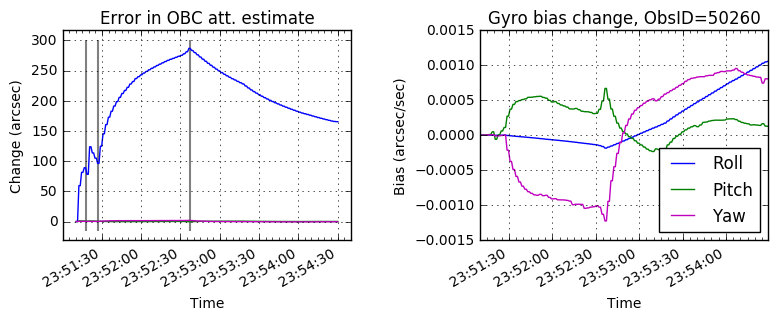

In [15]:
print('\nObsID=50260 (before manvr. prior to NSM)')
print('Vertical lines:')
print('   Replace ACQ for GUI star in slot 7')
print('   Drop images in slots 1 and 4 (both are reacquired soon after)')
print('   Kalman lock, drop image in slot 4')

# Times when Roll bias error in OBC estimate changes its behavior
t_gui = '2017:065:23:51:18.000'
t_drop14 = '2017:065:23:51:27.000'
t_roll = '2017:065:23:52:37.000' # drop 4 (7 dropped earlier)

plt.figure(figsize=(7.5, 3))

plt.subplot(1, 2, 1)

label = 'Error in OBC att. estimate'
plot_att_changes(refs=grnd_sol2, atts=obc_sol, label=label)
plt.vlines(DateTime([t_gui, t_drop14, t_roll]).plotdate,
           plt.ylim()[0], plt.ylim()[1],
           color='gray', linestyle='solid', lw=1.5)

plt.subplot(1, 2, 2)

colors = 'bgm'
for i, msid in enumerate(msids):
    plot_cxctime(telem[msid].times,
                 ((telem[msid].vals - telem[msid].vals[0]) * u.radian / u.s).to('arcsec/s'),
                 color=colors[i], label=axes[i])

plt.ylabel('Bias (arcsec/sec)')
plt.xlabel('Time')
plt.title('Gyro bias change, ObsID=50260')
plt.legend(loc='best')
plt.grid();

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45)


ObsID=50260 (before manvr. prior to NSM)


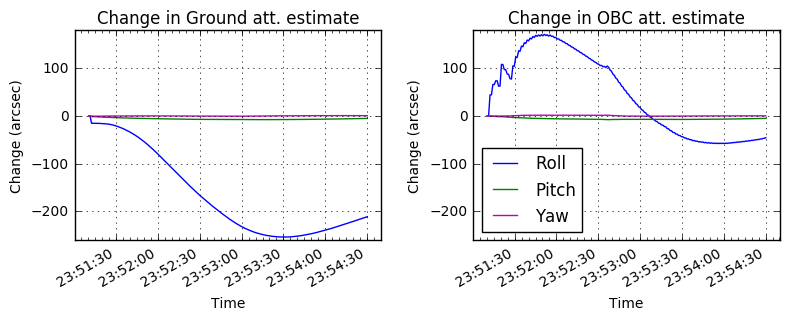

In [16]:
print('\nObsID=50260 (before manvr. prior to NSM)')

plt.figure(figsize=(7.5, 3))

plt.subplot(1, 2, 1)

label = 'Change in Ground att. estimate'
plot_att_changes(refs=grnd_sol2[:1], atts=grnd_sol2, label=label)
plt.ylim(-260, 180)

plt.subplot(1, 2, 2)

label = 'Change in OBC att. estimate'
plot_att_changes(refs=grnd_sol2[:1], atts=obc_sol, label=label)
plt.ylim(-260, 180)
plt.legend(loc='best')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.3)

### Offset from the planned attitude, using star telemetry ###

In [17]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstart'][0]
stop = tab['tstop'][1] - 1400
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

# Define reference times for average mag, yan, zan calculations
start_av = tab['tstop'][0] + 180
stop_av = tab['tstart'][1] - 5

times = [[start_av, stop_av]] * 6
times.insert(4, [start_av - 5, stop_av - 125])
times.append([start_av + 95, stop_av])

t = get_av_telem_from_stars(msids_star, times)

In [18]:
# Add telemetry at the time just before the maneuver
ok = (np.abs(telem['aoacmag0'].times - obc_sol['time'][-1])).argmin()

vals = []
keys = ['aoacyan', 'aoaczan', 'aoacmag']
for slot in range(8):
    msids = [key + '{}'.format(slot) for key in keys]
    for msid in msids:
        vals.append(telem[msid].vals[ok])
vals = np.array(vals).reshape(3, 8, order='F')
for idx, key in enumerate(keys):
    t[key + '_last'] = vals[idx]
    t[key + '_last'].format = '%.3f'

In [19]:
print(t['slot', 'aoacyan', 'aoaczan', 'aoacmag'])

slot  aoacyan   aoaczan  aoacmag
---- --------- --------- -------
   0  2064.132  -456.657   5.938
   1   753.387  1211.985  10.181
   2  1441.313  2012.592   9.982
   3   476.776  -347.456   9.616
   4  1480.514 -2056.769  10.996
   5   767.047 -2223.313   9.592
   6 -1455.422  -975.623   7.875
   7 -2320.617  -322.014  10.804


Kadi's <code>find_attitude</code> tool identified stars in slots 0, 2, 3, 5, 6 with respective catalog stars.

__Star acquisition during ObsID 50260 <span style="color:crimson; style:bold">(red dashed lines)</span>.__

<div><img style="float: left" src='aca-movie-2017-065-23-51-00.png' width='670'><br><br>__&nbsp;2017:065:23:51:00__</div>
<div><img style="float: left" src='aca-movie-2017-065-23-51-07.png' width='670'><br><br><br>__&nbsp;2017:065:23:51:07__</div>
<div><img style="float: left" src='aca-movie-2017-065-23-51-18.png' width='670'><br><br>__&nbsp;2017:065:23:51:18__<br> In slot 7 replace<br> ACQ with GUI star</div>
<div><img style="float: left" src='aca-movie-2017-065-23-51-27.png' width='670'><br>__&nbsp;2017:065:23:51:27__<br>Drop images in<br>slots 1 and 4</div>
<p>__Kalman lock__</p>
<div><img style="float: left" src='aca-movie-2017-065-23-51-35.png' width='670'><br><br>__&nbsp;2017:065:23:51:35__</div>
<div><img style="float: left" src='aca-movie-2017-065-23-53-18.png' width='670'><br><br><br>__&nbsp;2017:065:23:53:18__<br>Change in Roll bias</div>
<div><img style="float: left" src='aca-movie-2017-065-23-53-22.png' width='670'><br><br><br>__&nbsp;2017:065:23:53:22__</div>
<div><img style="float: left" src='aca-movie-2017-065-23-54-43.png' width='670'><br><br><br>__&nbsp;2017:065:23:54:43__</div>

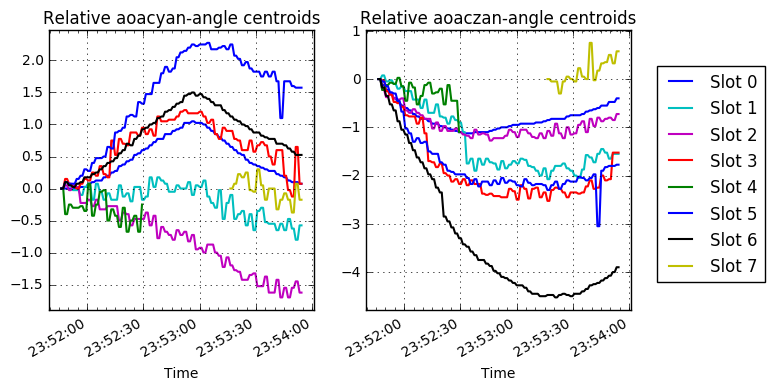

In [55]:
plt.figure(figsize=(7.5, 4))

colors = 'bcmrgbky'

for idx, coord in enumerate('yz'):
    plt.subplot(1, 2, idx + 1)
    coord = 'aoac{}an'.format(coord)
    relative_centroids(range(8), coord, colors,
                   'Relative {}-angle centroids'.format(coord))
    
plt.legend(loc=(1.1, 0.1));

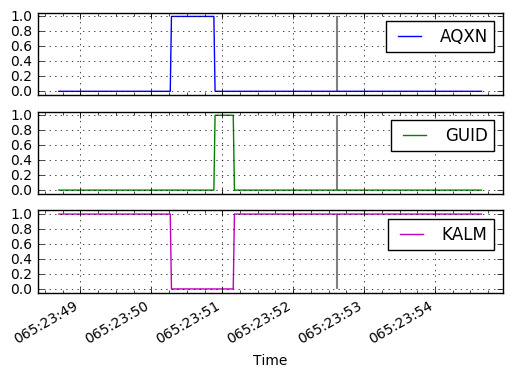

In [20]:
start_50260 = tab['tstop'][0]
stop_50260 = tab['tstart'][1]
telem1 = fetch.MSID('aoacaseq', start=start_50260, stop=stop_50260)

seqs = np.unique(telem1.vals)

colors = 'bgm'
for i, seq in enumerate(seqs):
    vals = telem1.vals == seq
    plt.subplot(3, 1, i + 1)
    plot_cxctime(telem1.times, vals, color=colors[i], label=seq)
    # Time when Roll bias changes its behavior
    plt.vlines([DateTime(t_roll).plotdate], plt.ylim()[0], plt.ylim()[1],
               color='gray', linestyle='solid', lw=1.5)
    plt.margins(0.05)
    plt.xlabel('Time')
    plt.grid()
    plt.legend()

In [21]:
msids = ['aoacfct{}'.format(i) for i in range(8)]
telem1 = fetch.MSIDset(msids, start=start_50260, stop=stop_50260)

unique = []
for msid in msids:
    unique.append(np.unique(telem1[msid].vals))

unique = np.unique(unique)

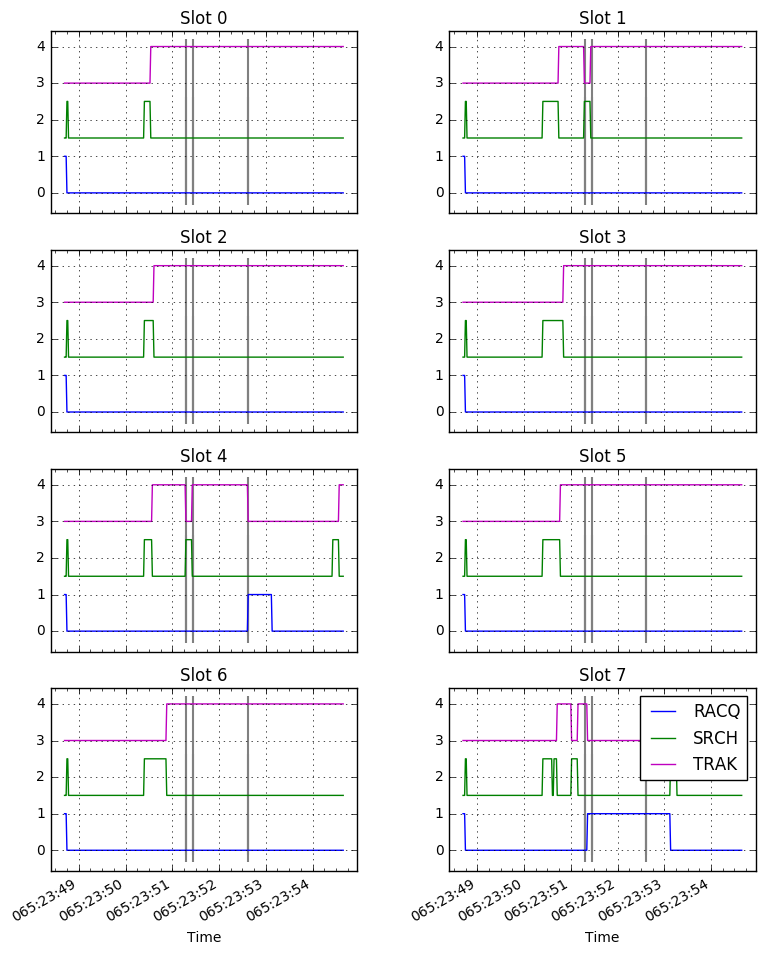

In [22]:
plt.figure(figsize=(7.5, 12))

colors = 'bgmy'
for i, msid in enumerate(msids):
    for ii, fct in enumerate(unique[1:]):
        vals = telem1[msid].vals == fct
        plt.subplot(4, 2, i + 1)
        plot_cxctime(telem1[msid].times, vals + ii * 1.5, color=colors[ii], label=fct)
        # Time when Roll bias changes its behavior
        plt.vlines(DateTime([t_gui, t_drop14, t_roll]).plotdate, plt.ylim()[0], plt.ylim()[1],
                   color='gray', linestyle='solid', lw=1.5)
        plt.margins(0.05)
        plt.xlabel('Time')
        plt.grid()
        plt.title('Slot {}'.format(i))

plt.legend()
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.3)

White: ObsID 50260
Gray: Maneuvers
Black: Time at which Roll bias changes its behavior, it coincides with dropping the (imposter) star in slot 4
Red: time intervals used to compute average telemetry
Titles: average mag, yan, zan


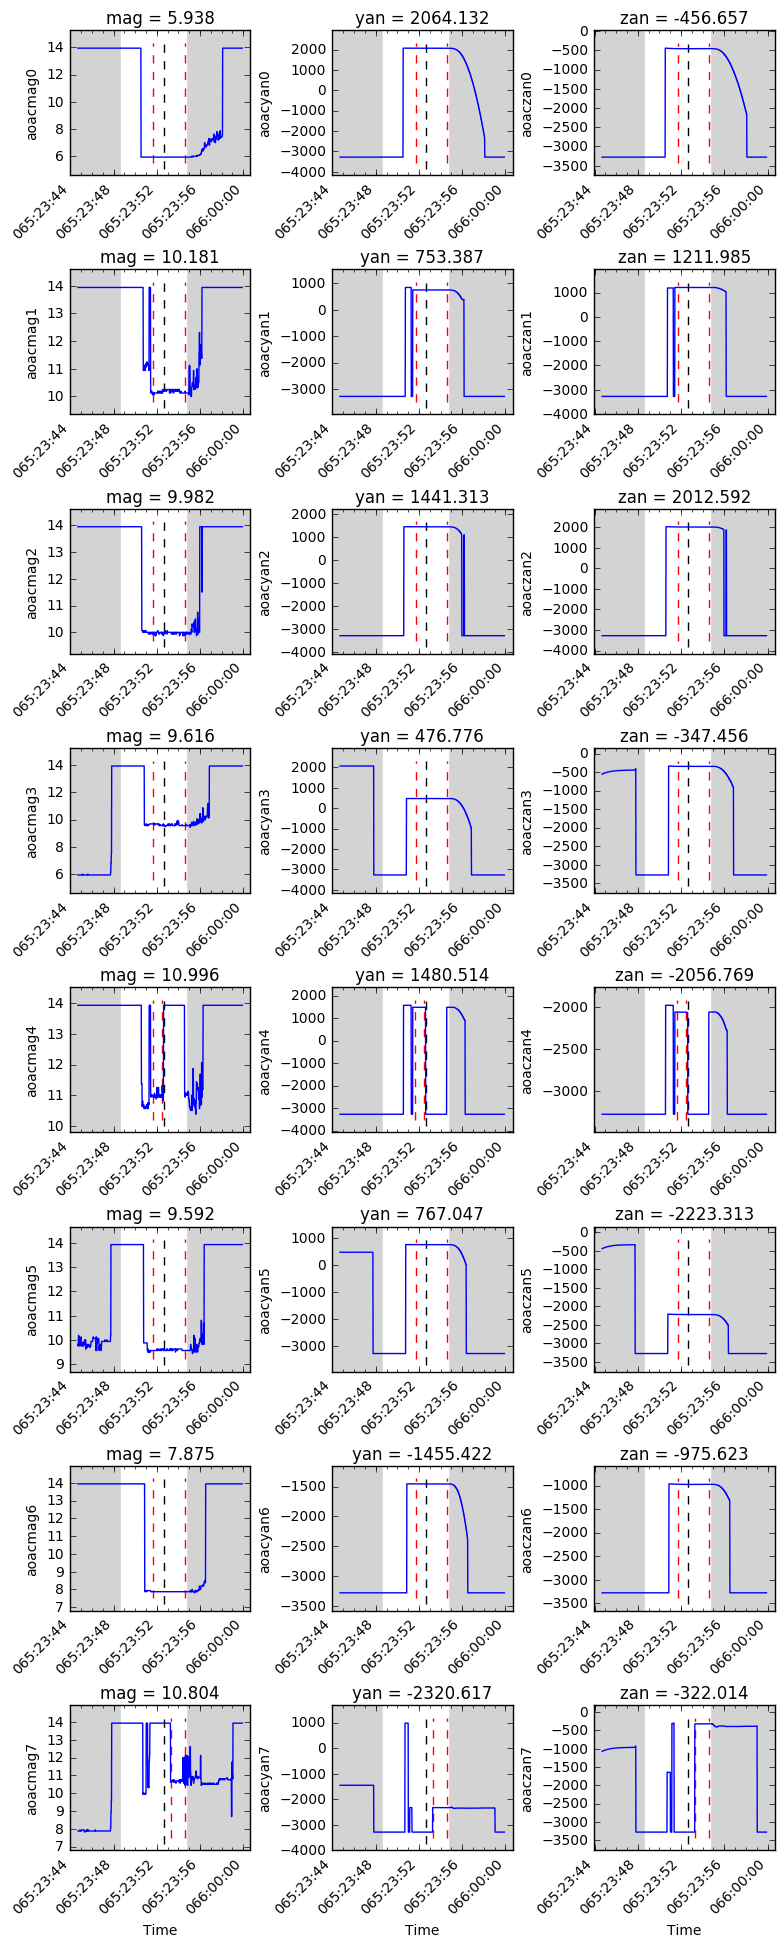

In [22]:
obs_times = DateTime([start_50260, stop_50260]).plotdate

print('White: ObsID 50260')
print('Gray: Maneuvers')
print('Black: Time at which Roll bias changes its behavior, it coincides with dropping the (imposter) star in slot 4')
print('Red: time intervals used to compute average telemetry')
print('Titles: average mag, yan, zan')

ffs = {'time': [t_roll], 'color': ['k']}
plot_telem(msids_star, times, obs_times, ffs=ffs)

__Attitude solutions.__ Kadi input:
   1. All 8 slots, average telemetry.
   2. Slots 0, 2, 3, 5, 6 (stars identified with Kadi), average telemetry.
   3. Slots 0, 2, 3, 5, 6 (stars identified with Kadi), telemetry at the time just before the maneuver before NSM.
   4. Slots 0, 2, 3, 5 (see the plot with relative centroids), telemetry at the time just before the maneuver before NSM.

In [72]:
# Kadi, attitude solution (input: all slots):
#
# Attitude solution
# Coordinates
#
# RA=216.52043853
# Dec=37.8175070084
# Roll=113.948811699
#
# Q1=0.0808060442687
# Q2=-0.808580454805
# Q3=-0.404505000477
# Q4=0.419575661718
#
#  
# Star match summary and residuals 
#
# slot    YAG       ZAG    MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
# ---- --------- --------- ------- -------- ----- -------- ----- ---- ----------
#   0  2064.132  -456.657   5.938  2064.14 -0.01  -457.00  0.34 0.34  397805704
#   1   753.387  1211.985  10.181       --    --       --    --   --         --
#   2  1441.313  2012.592   9.982  1441.34 -0.03  2013.30 -0.71 0.71  397807608
#   3   476.776  -347.456   9.616   476.77  0.01  -347.63  0.17 0.17  397808560
#   4  1480.514 -2056.769  10.996       --    --       --    --   --         --
#   5   767.047 -2223.313   9.592   767.44 -0.39 -2223.73  0.42 0.57  397940208
#   6 -1455.422  -975.623   7.875 -1455.84  0.42  -975.40 -0.22 0.48  397943760
#   7 -2320.617  -322.014  10.804       --    --       --    --   --         --
  
Q1 = 0.0808060442687
Q2 = -0.808580454805
Q3 = -0.404505000477
Q4 = 0.419575661718
    
q_kadi_all = Quat([Q1, Q2, Q3, Q4])

print('All 8 slots, average telemetry:\n')
result = get_att_offset(q_kadi_all, q_planned)

All 8 slots, average telemetry:

Offset = 10.2 arcsec
d(Roll) = 142.8 arcsec
d(Pitch) = 7.8 arcsec
d(Yaw) = -6.6 arcsec


In [73]:
# Kadi, attitude solution (input: only slots 0, 2, 3, 5, 6):
#
# Attitude solution
# Coordinates
#
# RA=216.520438558
# Dec=37.8175070267
# Roll=113.94881085
#
# Q1=0.0808060412669
# Q2=-0.808580451772
# Q3=-0.404505006298
# Q4=0.419575662528
#
#  
# Star match summary and residuals 
#
# slot    YAG       ZAG    MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
# ---- --------- --------- ------- -------- ----- -------- ----- ---- ----------
#   0  2064.132  -456.657   5.938  2064.14 -0.01  -457.00  0.34 0.34  397805704
#   2  1441.313  2012.592   9.982  1441.34 -0.03  2013.30 -0.71 0.71  397807608
#   3   476.776  -347.456   9.616   476.77  0.01  -347.63  0.17 0.17  397808560
#   5   767.047 -2223.313   9.592   767.44 -0.39 -2223.73  0.42 0.57  397940208
#   6 -1455.422  -975.623   7.875 -1455.85  0.42  -975.40 -0.22 0.48  397943760

Q1 = 0.0808060412669
Q2 = -0.808580451772
Q3 = -0.404505006298
Q4 = 0.419575662528

q_kadi_good = Quat([Q1, Q2, Q3, Q4])

print('Slots 0, 2, 3, 5, 6 (stars identified with Kadi), average telemetry:\n')
result = get_att_offset(q_kadi_good, q_planned)

Slots 0, 2, 3, 5, 6 (stars identified with Kadi), average telemetry:

Offset = 10.2 arcsec
d(Roll) = 142.8 arcsec
d(Pitch) = 7.8 arcsec
d(Yaw) = -6.6 arcsec


In [34]:
ok = np.array([1, 0, 1, 1, 0, 1, 1, 0], dtype=bool)
print(t['slot', 'aoacyan_last', 'aoaczan_last', 'aoacmag_last'][ok])

slot aoacyan_last aoaczan_last aoacmag_last
---- ------------ ------------ ------------
   0     2063.550     -455.075        5.938
   2     1441.000     2013.650        9.875
   3      475.550     -345.475        9.562
   5      766.750    -2221.825        9.562
   6    -1455.775     -974.250        7.875


In [74]:
# Kadi, find_attitude at the time just before the maneuver before NSM
#
# Attitude solution
# Coordinates
#
# RA=216.520840539
# Dec=37.8178164088
# Roll=113.948614365
#
# Q1=0.0808066064843
# Q2=-0.808579214282
# Q3=-0.404503797038
# Q4=0.419579104296
#
#  
# Star match summary and residuals 
#
# slot    YAG       ZAG    MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
# ---- --------- --------- ------- -------- ----- -------- ----- ---- ----------
#   0   2063.55  -455.075   5.938  2063.59 -0.04  -455.50  0.43 0.43  397805704
#   2    1441.0   2013.65   9.875  1440.79  0.21  2014.80 -1.15 1.17  397807608
#   3    475.55  -345.475   9.562   476.21 -0.66  -346.13  0.66 0.93  397808560
#   5    766.75 -2221.825   9.562   766.88 -0.13 -2222.23  0.41 0.43  397940208
#   6 -1455.775   -974.25   7.875 -1456.40  0.62  -973.90 -0.35 0.71  397943760

Q1 = 0.0808066064843
Q2 = -0.808579214282
Q3 = -0.404503797038
Q4 = 0.419579104296

q_kadi = Quat([Q1, Q2, Q3, Q4])

print('Slots 0, 2, 3, 5, 6 (stars identified with Kadi), at the time just before the maneuver before NSM:\n')
result = get_att_offset(q_kadi, q_planned)

Slots 0, 2, 3, 5, 6 (stars identified with Kadi), at the time just before the maneuver before NSM:

Offset = 9.5 arcsec
d(Roll) = 142.7 arcsec
d(Pitch) = 6.3 arcsec
d(Yaw) = -7.2 arcsec


In [75]:
# Kadi, find_attitude at time just before the maneuver, only stars 0, 2, 3, 5
#
# Attitude solution
# Coordinates
#
# RA=216.520899832
# Dec=37.8178747921
# Roll=113.95596568
#
# Q1=0.0808336488652
# Q2=-0.808605071491
# Q3=-0.404451494794
# Q4=0.419574484364
#
#  
# Star match summary and residuals 
#
# slot   YAG      ZAG    MAG_ACA  m_yag    dy   m_zag     dz   dr  m_agasc_id
# ---- ------- --------- ------- ------- ----- -------- ----- ---- ----------
#   0 2063.55  -455.075   5.938 2063.40  0.15  -455.53  0.46 0.48  397805704
#   2  1441.0   2013.65   9.875 1440.93  0.07  2014.85 -1.20 1.21  397807608
#   3  475.55  -345.475   9.562  476.05 -0.50  -345.95  0.48 0.69  397808560
#   5  766.75 -2221.825   9.562  766.47  0.28 -2222.09  0.27 0.39  397940208

Q1 = 0.0808336488652
Q2 = -0.808605071491
Q3 = -0.404451494794
Q4 = 0.419574484364

q_kadi_4 = Quat([Q1, Q2, Q3, Q4])

print('Slots 0, 2, 3, 5 (see relative centroids), at the time just before the maneuver before NSM:\n')
result = get_att_offset(q_kadi_4, q_planned)

Slots 0, 2, 3, 5 (see relative centroids), at the time just before the maneuver before NSM:

Offset = 9.5 arcsec
d(Roll) = 116.1 arcsec
d(Pitch) = 6.0 arcsec
d(Yaw) = -7.3 arcsec


In [76]:
msids = ['aoattqt{}'.format(i + 1) for i in range(4)]
telem = fetch.MSIDset(msids, start=obc_sol['time'][0], stop=obc_sol['time'][-1])

q_obc = [telem[msids[i]].vals[0] for i in range(4)]
q_obc = Quat(q_obc)

print('Offset between OBC and kadi estimated attitudes at the start of KALMAN:\n')
result = get_att_offset(q_kadi, q_obc)

q_obc = [telem[msids[i]].vals[-1] for i in range(4)]
q_obc = Quat(q_obc)

print('\nOffset between OBC and kadi estimated attitudes just before the maneuver before NSM:\n')
result = get_att_offset(q_kadi, q_obc)

Offset between OBC and kadi estimated attitudes at the start of KALMAN:

Offset = 5.1 arcsec
d(Roll) = 143.5 arcsec
d(Pitch) = 5.1 arcsec
d(Yaw) = -0.9 arcsec

Offset between OBC and kadi estimated attitudes just before the maneuver before NSM:

Offset = 0.7 arcsec
d(Roll) = 97.0 arcsec
d(Pitch) = 0.3 arcsec
d(Yaw) = -0.6 arcsec


In [79]:
q_obc_sol = obc_sol['q_att'][0]
dq = Quat(q_obc_sol).dq(q_obc)

q_grnd_sol = grnd_sol2['q_att'][0]
q_grnd = Quat(q_grnd_sol) * dq

print('Offset between Ground and kadi estimated attitudes at the start of KALMAN:\n')
result = get_att_offset(q_kadi, q_grnd)

q_obc_sol = obc_sol['q_att'][-1]
dq = Quat(q_obc_sol).dq(q_obc)

q_grnd_sol = grnd_sol2['q_att'][-1]
q_grnd = Quat(q_grnd_sol) * dq

print('\nOffset between Ground and kadi estimated attitudes just before the maneuver before NSM:\n')
result = get_att_offset(q_kadi, q_grnd)

Offset between Ground and kadi estimated attitudes at the start of KALMAN:

Offset = 0.7 arcsec
d(Roll) = 97.0 arcsec
d(Pitch) = 0.4 arcsec
d(Yaw) = -0.6 arcsec

Offset between Ground and kadi estimated attitudes just before the maneuver before NSM:

Offset = 0.3 arcsec
d(Roll) = -68.4 arcsec
d(Pitch) = 0.1 arcsec
d(Yaw) = -0.2 arcsec


In [80]:
print('Offset between obc and ground estimated attitudes just before the maneuver before NSM:\n')
result = get_att_offset(q_obc, q_grnd)

Offset between obc and ground estimated attitudes just before the maneuver before NSM:

Offset = 0.4 arcsec
d(Roll) = -165.5 arcsec
d(Pitch) = -0.2 arcsec
d(Yaw) = 0.4 arcsec


## OBSID=50259 ##

### Star acquisition during ObsID=50259, and during full field search at the start of the NSM transition###

In [31]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstop'][1]
stop = '2017:066:00:28:00'
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

In [32]:
# Define reference times
tstart_acq = DateTime('2017:066:00:24:05.000').secs
tstop_acq = DateTime('2017:066:00:24:20.000').secs
times = [tstart_acq, tstop_acq]

time_ffs = DateTime('2017:066:00:25:33.000').secs
ok = (np.abs(telem['aoacmag0'].times - time_ffs)).argmin()

In [33]:
t = get_av_telem_from_stars(msids_star, times, ffs=True)

__Images acquired at <code>2017:066:00:24:30</code> <span style="color:crimson; style:bold">(red dashed lines)</span>, approximately 3 sec prior to the NSM transition.__ None of them is a star image.

<img style="float: left;" src='aca-movie-2017-066-00-24-30.png' width='750'>

In [34]:
ok = t['aoacmag'] < 13
print('Telemetry acquired during the ObsID=50259 star acquisition:\n')
print(t['slot', 'aoacyan', 'aoaczan', 'aoacmag'][ok])

Telemetry acquired during the ObsID=50259 star acquisition:

slot aoacyan   aoaczan  aoacmag
---- -------- --------- -------
   0 -824.562 -2005.043  10.950
   1 -741.210 -1822.615  10.396
   7 1956.518 -1684.533  10.504


In [35]:
# No Kadi attitude solution: min 4 stars required

White: ObsID 50259
Gray: Maneuvers
Red: failed star acquisition
Black: time of full field search used to access star telemetry for offset computations
Titles: mag, yan and zan at the time marked with black line


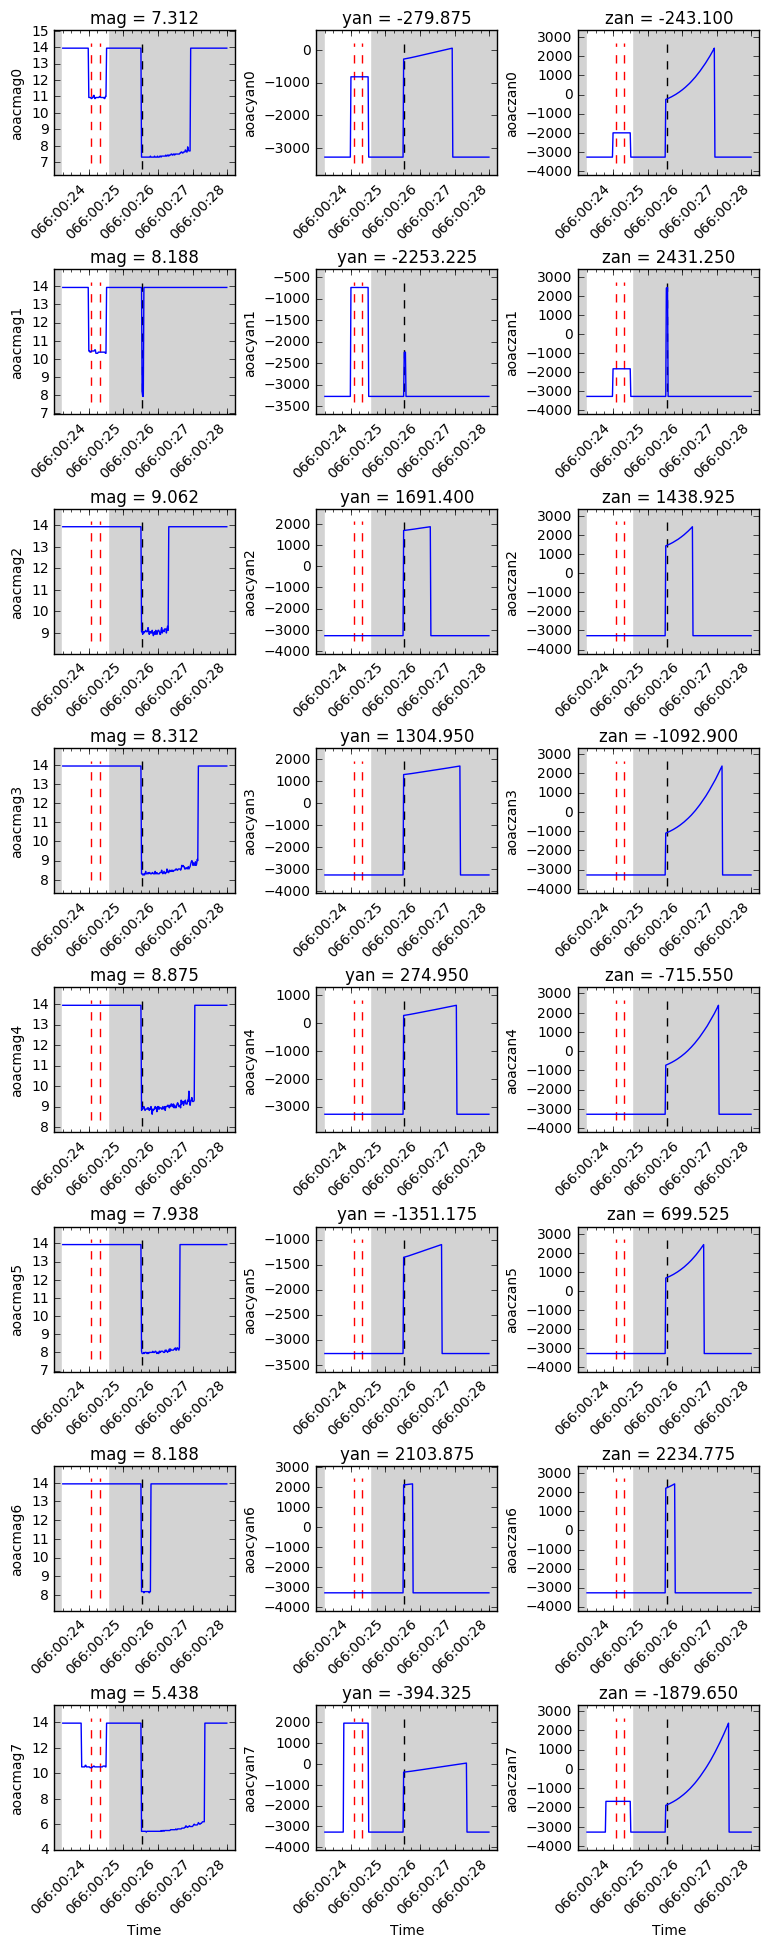

In [36]:
start_50259 = start
stop_50259 = time_nsm
obs_times = DateTime([start_50259, stop_50259]).plotdate

print('White: ObsID 50259')
print('Gray: Maneuvers')
print('Red: failed star acquisition')
print('Black: time of full field search used to access star telemetry for offset computations')
print('Titles: mag, yan and zan at the time marked with black line')

ffs = {'time': [time_ffs], 'color': ['k']}
plot_telem(msids_star, times, obs_times, ffs=ffs)

In [37]:
print('Stars acquired during the full field search:\n')
print(t['slot', 'aoacyan_ffs', 'aoaczan_ffs', 'aoacmag_ffs'])

Stars acquired during the full field search:

slot aoacyan_ffs aoaczan_ffs aoacmag_ffs
---- ----------- ----------- -----------
   0    -279.875    -243.100       7.312
   1   -2253.225    2431.250       8.188
   2    1691.400    1438.925       9.062
   3    1304.950   -1092.900       8.312
   4     274.950    -715.550       8.875
   5   -1351.175     699.525       7.938
   6    2103.875    2234.775       8.188
   7    -394.325   -1879.650       5.438


### Offset from the planned attitude, using star telemetry ###

Kadi's <code>find_attitude</code> tool:
   * Five stars acquired at the start of the NSM were identified as the commanded catalog stars (slot/catalog slot number): 0/5, 2/2, 4/6, 5/3, 6/4.
   * Stars in slots 3 and 7 are in agasc catalog but were not included in the commanded catalog.
   * Star in slot 1 was not identified.

In [38]:
# Kadi, find_attitude
#
# Attitude solution
# Coordinates
#
# RA=150.496217865
# Dec=31.4310743185
# Roll=214.93547334
#
# Q1=-0.155187853786
# Q2=-0.908663993779
# Q3=0.21363345805
# Q4=0.323430397532
#
#  
# Star match summary and residuals 
#
# slot    YAG      ZAG    MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id    50259_catalog_slot
# ---- --------- -------- ------- -------- ----- -------- ----- ---- ----------
#   0  -279.875   -243.1   7.312  -280.05  0.18  -243.13  0.03 0.18  328081352     5
#   1 -2253.225  2431.25   8.188       --    --       --    --   --         --     --
#   2    1691.4 1438.925   9.062  1691.98 -0.58  1438.67  0.26 0.64  328078016     2
#   3   1304.95  -1092.9   8.312  1305.04 -0.09 -1093.13  0.23 0.24  327951064     ???
#   4    274.95  -715.55   8.875   275.27 -0.32  -714.81 -0.74 0.80  328081440     6
#   5 -1351.175  699.525   7.938 -1351.26  0.09   699.54 -0.02 0.09  328078824     3
#   6  2103.875 2234.775   8.188  2103.18  0.69  2234.56  0.21 0.72  328081232     4
#   7  -394.325 -1879.65   5.438  -394.36  0.04 -1879.67  0.02 0.04  328085344     ???

q_kadi = Quat([-0.155187853786, -0.908663993779, 0.21363345805, 0.323430397532])

# OBSID = 50259
# MP_TARGQUAT at 2017:065:23:54:34.470 (VCDU count = 6626333)
#  Q1,Q2,Q3,Q4: -0.15519481  -0.90893399  0.21402725  0.32240644
q_planned = Quat([-0.15519481, -0.90893399, 0.21402725, 0.32240644])

result = get_att_offset(q_kadi, q_planned)

d(Roll) = 57.2 arcsec
d(Pitch) = -444.5 arcsec
d(Yaw) = 128.0 arcsec

Offset = 462.5 arcsec


Not reliable because the spacecraft was already slewing to the NSM position. Instead:
1. From telemetry, find att. estimates (<code>aoattqt</code>) at the time of full field search and at the time of ObsID=50259 star acquisition.
2. Derive dq between these two att. estimates.
3. Apply dq to the attitude estimated from the full field search telemetry, <code>q_kadi</code>, and thus derive the 'true' attitude at the time of ObsID=50259 star acquisition.
4. Compute offset between the 'true' and planned attitudes.

In [39]:
# Find indexes corresponding to start/stop times of AQXN and
# time of the full field search

start = tab['tstop'][1]
stop = time_ffs + 10

telem = fetch.MSID('aoacaseq'.format(i), start=start, stop=stop)

i_start_aqxn = list(telem.vals).index('AQXN')
i_stop_aqxn = len(telem.vals) - 1 - list(telem.vals[::-1]).index('AQXN')
i_ffs = (np.abs(telem.times - time_ffs)).argmin()

# Find quaternions corresponding to start/stop AQXN times and time of FFS

msids = ['aoattqt1', 'aoattqt2', 'aoattqt3', 'aoattqt4']
telem = fetch.MSIDset(msids, start=start, stop=stop)

quats = []
for i in [i_start_aqxn, i_stop_aqxn, i_ffs]:
    q = []
    for msid in msids:
        q.append(telem[msid].vals[i])
    quats.append(q)

quats = [Quat(q) for q in quats]

In [40]:
# Find maneuver from est. att. at the time of full field search back to est. att. at the start of AQXN
dq = quats[2].dq(quats[0])

# Apply this maneuver to att. found with kadi (at the time of full field search) to get 'true' att. at the start of AQXN
q_true = q_kadi * dq

# Find attitude offset from the planned direction at the start of AQXN
result = get_att_offset(q_true, q_planned)

d(Roll) = 87.1 arcsec
d(Pitch) = -134.7 arcsec
d(Yaw) = 48.8 arcsec

Offset = 143.3 arcsec
